# Dimensionality Reduction for Business Analytics
## Digital Nomad Cities Case Study

### Learning Objectives

- Understand when and why dimensionality reduction is essential for business analytics
- Apply PCA to discover key factors driving complex business phenomena  
- Compare PCA, NMF, and UMAP approaches for different business contexts
- Interpret reduced-dimension results for business stakeholders
- Create compelling visualizations that communicate data insights

## 1. Business Problem Setup

### The Digital Nomad Revolution

The digital nomad market has exploded to over 40 million remote workers worldwide in 2024. These location-independent professionals face a complex decision: **where should they live next?**

With 780+ cities to choose from and 21+ factors to consider (cost, safety, internet speed, social environment, etc.), the choice is overwhelming. Traditional travel guides can't capture the nuanced trade-offs that matter to remote workers.

**Business Challenge:** How do we transform this 21-dimensional decision space into clear, actionable insights that help nomads make better location choices?

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

In [ ]:
# Load the digital nomad cities dataset
data = pd.read_csv('https://sds-aau.github.io/SDS-master/M1/data/cities.csv')

print(f"Dataset shape: {data.shape}")
print(f"Cities analyzed: {data.shape[0]}")
print(f"Total variables: {data.shape[1]}")
print(f"Numerical variables for analysis: {data.select_dtypes(include=[np.number]).shape[1]}")

Dataset shape: (780, 25)
Cities analyzed: 780
Total variables: 25
Numerical variables for analysis: 21


In [ ]:
# Explore the complexity of the decision space
print("Sample of cities and their characteristics:")
print(data.head())
print("\nDataset info:")
print(data.info())

Sample of cities and their characteristics:
        place alpha-2  region          sub-region  cost_nomad  cost_coworking  \
0    Budapest      HU  Europe      Eastern Europe      1364.0          152.41   
1  Chiang Mai      TH    Asia  South-eastern Asia       777.0           98.88   
2      Phuket      TH    Asia  South-eastern Asia      1012.0          155.43   
3     Bangkok      TH    Asia  South-eastern Asia      1197.0          131.41   
4    Ko Samui      TH    Asia  South-eastern Asia      1352.0          169.56   

   cost_expat  coffee_in_cafe  cost_beer  places_to_work  ...  \
0      1273.0            1.73       1.73             1.0  ...   
1       780.0            0.85       0.85             0.8  ...   
2      1714.0            1.41       1.41             0.8  ...   
3      1158.0            2.12       2.12             1.0  ...   
4      1347.0            1.41       1.41             0.8  ...   

   fragile_states_index  press_freedom_index  female_friendly  lgbt_friendly  

In [ ]:
data[data.place == "Chengdu"]

,place,alpha-2,region,sub-region,cost_nomad,cost_coworking,cost_expat,coffee_in_cafe,cost_beer,places_to_work,...,fragile_states_index,press_freedom_index,female_friendly,lgbt_friendly,friendly_to_foreigners,racism,leisure,life_score,nightlife,weed
483,Chengdu,CN,Asia,Eastern Asia,944.0,88.96,919.0,1.09,1.09,0.6,...,74.9,80.96,0.8,0.6,0.6,0.4,0.6,0.6,0.6,0.0


## Understanding the Decision Complexity

In [ ]:
# Examine the range and scale of different variables
numerical_cols = data.select_dtypes(include=[np.number]).columns
print("Variable ranges demonstrate the scaling challenge:")
print("\nCost variables (likely in dollars):")
cost_vars = [col for col in numerical_cols if 'cost' in col or 'coffee' in col or 'beer' in col]
print(data[cost_vars].describe())

print("\nScore variables (likely 0-10 scales):")
score_vars = [col for col in numerical_cols if 'score' in col or 'friendly' in col or 'safety' in col]
print(data[score_vars].describe())

Variable ranges demonstrate the scaling challenge:

Cost variables (likely in dollars):
         cost_nomad  cost_coworking    cost_expat  coffee_in_cafe   cost_beer
count    780.000000      780.000000    780.000000      780.000000  780.000000
mean    2331.748718      210.268667   1880.914103        3.296718    3.296718
std     1118.123362      174.071641   1266.151244        1.982981    1.982981
min      387.000000        0.010000    296.000000        0.000000    0.000000
25%     1486.000000       88.960000   1010.000000        1.600000    1.600000
50%     2208.500000      171.300000   1646.000000        3.060000    3.060000
75%     3057.000000      275.962500   2409.750000        4.622500    4.622500
max    10121.000000     1524.460000  13406.000000       13.720000   13.720000

Score variables (likely 0-10 scales):
       freedom_score   peace_score      safety  female_friendly  \
count   7.800000e+02  7.800000e+02  780.000000       780.000000   
mean    4.712821e-01  6.515385e-01   

# 2. Data Preprocessing: The Foundation of Good Analysis

## Why Scaling Matters for Dimensionality Reduction

Different variables are measured on completely different scales. Without proper scaling, PCA will be dominated by variables with the largest numeric ranges (like cost_nomad) rather than finding true patterns.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Prepare data for analysis - select only numerical variables
data_for_analysis = data.select_dtypes(include=[np.number])
print(f"Variables included in analysis: {list(data_for_analysis.columns)}")
print(f"Total variables: {len(data_for_analysis.columns)}")

Variables included in analysis: ['cost_nomad', 'cost_coworking', 'cost_expat', 'coffee_in_cafe', 'cost_beer', 'places_to_work', 'free_wifi_available', 'internet_speed', 'freedom_score', 'peace_score', 'safety', 'fragile_states_index', 'press_freedom_index', 'female_friendly', 'lgbt_friendly', 'friendly_to_foreigners', 'racism', 'leisure', 'life_score', 'nightlife', 'weed']
Total variables: 21


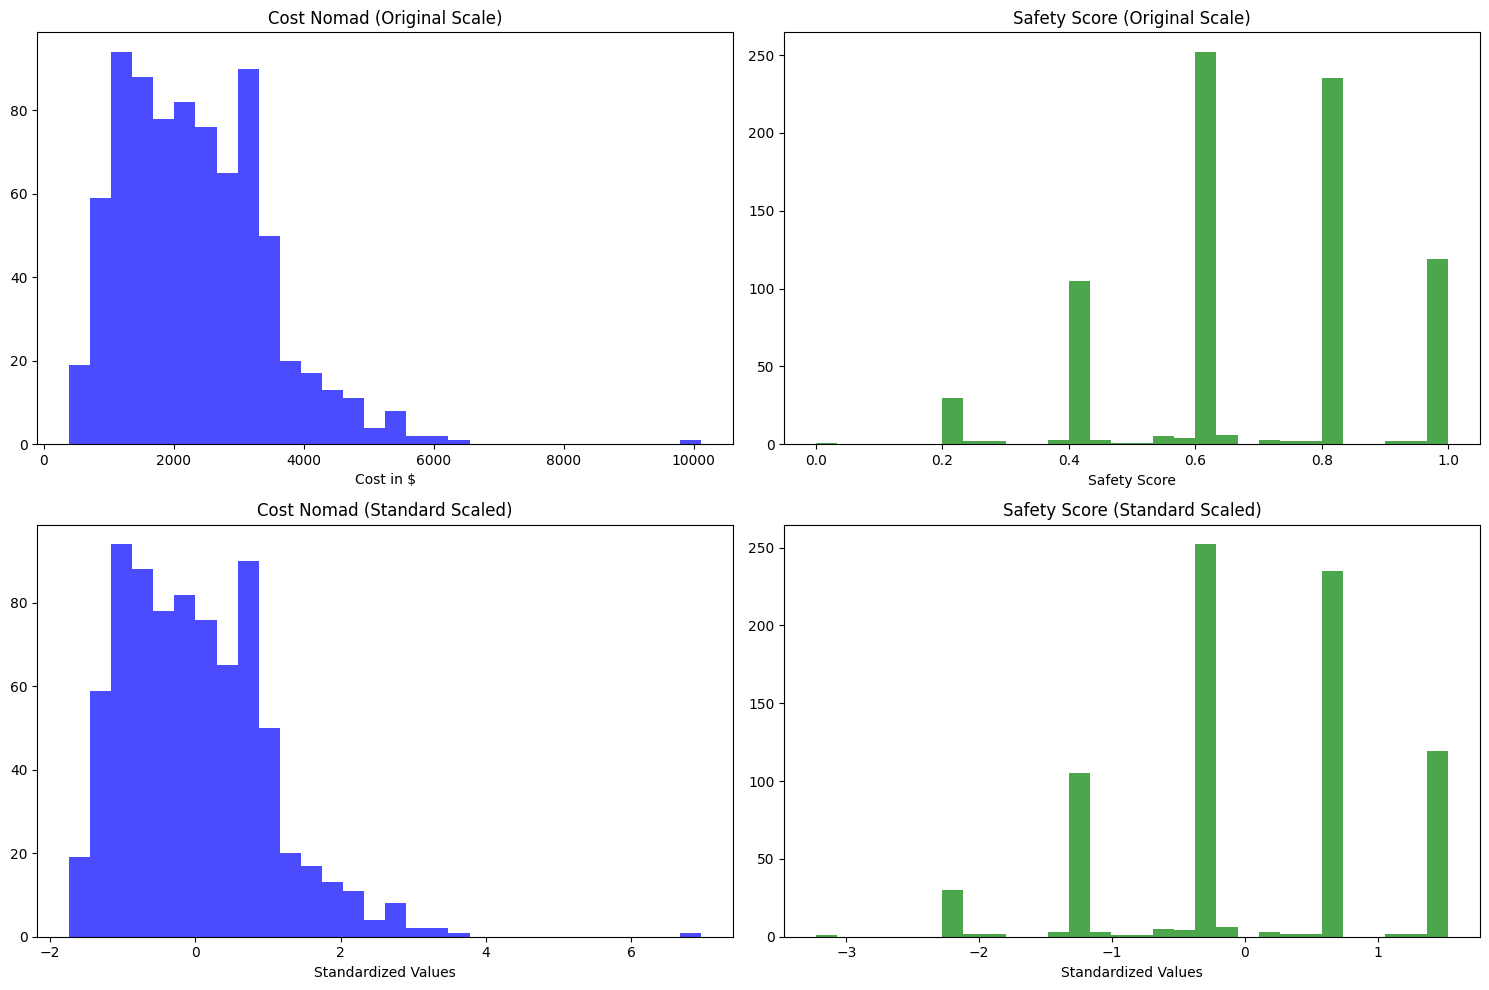

Standard Scaling: Mean = 0, Std = 1
Cost nomad - Mean: -0.000, Std: 1.001
Safety - Mean: 0.000, Std: 1.001


In [ ]:
# Compare scaling approaches
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original data - two very different scale variables
axes[0,0].hist(data_for_analysis['cost_nomad'], bins=30, alpha=0.7, color='blue')
axes[0,0].set_title('Cost Nomad (Original Scale)')
axes[0,0].set_xlabel('Cost in $')

axes[0,1].hist(data_for_analysis['safety'], bins=30, alpha=0.7, color='green')
axes[0,1].set_title('Safety Score (Original Scale)')
axes[0,1].set_xlabel('Safety Score')

# After StandardScaler
scaler_standard = StandardScaler()
data_standard_scaled = scaler_standard.fit_transform(data_for_analysis)
data_standard_df = pd.DataFrame(data_standard_scaled, columns=data_for_analysis.columns)

axes[1,0].hist(data_standard_df['cost_nomad'], bins=30, alpha=0.7, color='blue')
axes[1,0].set_title('Cost Nomad (Standard Scaled)')
axes[1,0].set_xlabel('Standardized Values')

axes[1,1].hist(data_standard_df['safety'], bins=30, alpha=0.7, color='green')
axes[1,1].set_title('Safety Score (Standard Scaled)')
axes[1,1].set_xlabel('Standardized Values')

plt.tight_layout()
plt.show()

print("Standard Scaling: Mean = 0, Std = 1")
print(f"Cost nomad - Mean: {data_standard_df['cost_nomad'].mean():.3f}, Std: {data_standard_df['cost_nomad'].std():.3f}")
print(f"Safety - Mean: {data_standard_df['safety'].mean():.3f}, Std: {data_standard_df['safety'].std():.3f}")

In [ ]:
# Alternative: MinMax Scaling (0-1 range)
scaler_minmax = MinMaxScaler()
data_minmax_scaled = scaler_minmax.fit_transform(data_for_analysis)
data_minmax_df = pd.DataFrame(data_minmax_scaled, columns=data_for_analysis.columns)

print("\nMinMax Scaling: Range = [0,1]")
print(f"Cost nomad - Min: {data_minmax_df['cost_nomad'].min():.3f}, Max: {data_minmax_df['cost_nomad'].max():.3f}")
print(f"Safety - Min: {data_minmax_df['safety'].min():.3f}, Max: {data_minmax_df['safety'].max():.3f}")


MinMax Scaling: Range = [0,1]
Cost nomad - Min: 0.000, Max: 1.000
Safety - Min: 0.000, Max: 1.000


**Key Business Insight:** StandardScaler preserves the relative spread of variables while equalizing their scales. This is crucial for PCA to find patterns based on correlation structure rather than variable magnitude.

# 3. PCA Implementation & Interpretation

## Principal Component Analysis: Finding the Essential Dimensions

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to our standardized data
pca = PCA()
pca_results = pca.fit_transform(data_standard_scaled)

# Examine explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("Explained Variance by Component:")
for i in range(min(10, len(explained_variance_ratio))):
    print(f"PC{i+1}: {explained_variance_ratio[i]:.3f} ({explained_variance_ratio[i]*100:.1f}%)")

print(f"\nFirst 3 components explain {cumulative_variance[2]*100:.1f}% of total variance")
print(f"First 5 components explain {cumulative_variance[4]*100:.1f}% of total variance")

Explained Variance by Component:
PC1: 0.395 (39.5%)
PC2: 0.094 (9.4%)
PC3: 0.061 (6.1%)
PC4: 0.054 (5.4%)
PC5: 0.048 (4.8%)
PC6: 0.042 (4.2%)
PC7: 0.037 (3.7%)
PC8: 0.035 (3.5%)
PC9: 0.033 (3.3%)
PC10: 0.030 (3.0%)

First 3 components explain 55.0% of total variance
First 5 components explain 65.1% of total variance


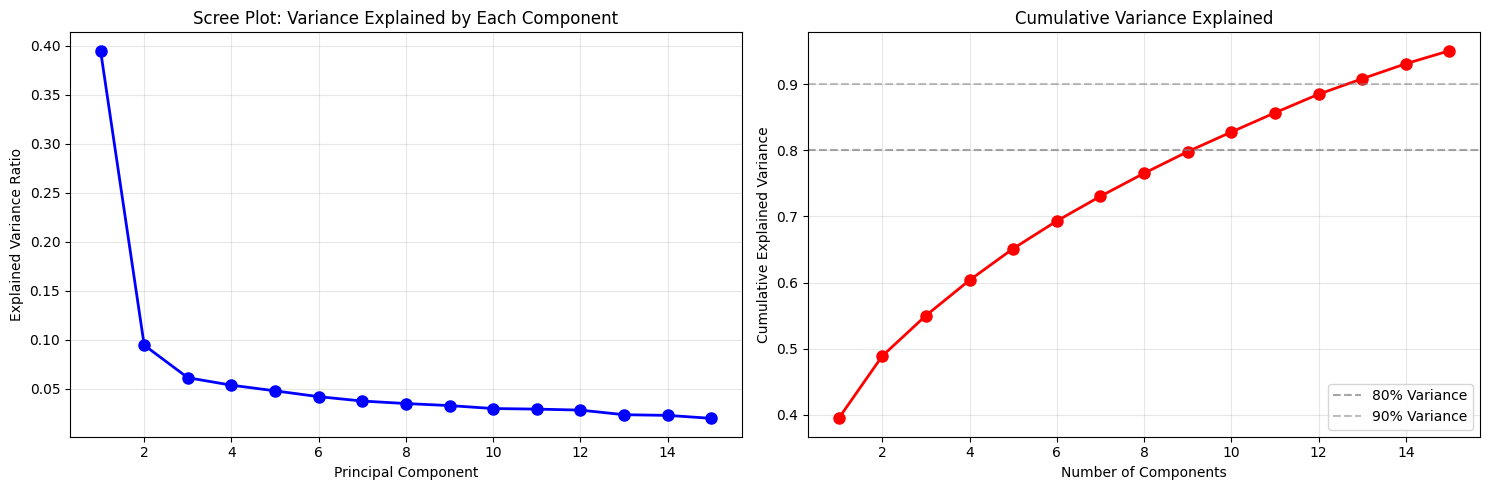

In [ ]:
# Visualize the explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Scree plot
ax1.plot(range(1, min(16, len(explained_variance_ratio)+1)),
         explained_variance_ratio[:15], 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Scree Plot: Variance Explained by Each Component')
ax1.grid(True, alpha=0.3)

# Cumulative variance
ax2.plot(range(1, min(16, len(cumulative_variance)+1)),
         cumulative_variance[:15], 'ro-', linewidth=2, markersize=8)
ax2.axhline(y=0.8, color='gray', linestyle='--', alpha=0.7, label='80% Variance')
ax2.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5, label='90% Variance')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Variance Explained')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Business Interpretation: What Do These Dimensions Mean?

In [ ]:
# Examine the first few principal components in detail
components_df = pd.DataFrame(
    pca.components_[:5].T,  # First 5 components
    columns=[f'PC{i+1}' for i in range(5)],
    index=data_for_analysis.columns
)

print("Principal Component Loadings (How much each variable contributes):")
print(components_df.round(3))

Principal Component Loadings (How much each variable contributes):
                          PC1    PC2    PC3    PC4    PC5
cost_nomad             -0.229  0.405  0.172 -0.016  0.025
cost_coworking         -0.150  0.371  0.150 -0.204  0.033
cost_expat             -0.208  0.324  0.177 -0.060  0.008
coffee_in_cafe         -0.261  0.341 -0.002 -0.010  0.018
cost_beer              -0.261  0.341 -0.002 -0.010  0.018
places_to_work         -0.169 -0.190  0.303  0.154 -0.023
free_wifi_available    -0.195 -0.141  0.006  0.072 -0.002
internet_speed         -0.163 -0.008 -0.064  0.409 -0.105
freedom_score          -0.280 -0.043 -0.236  0.152 -0.004
peace_score            -0.258 -0.086 -0.296  0.030 -0.027
safety                 -0.234 -0.189 -0.273 -0.252 -0.008
fragile_states_index    0.298  0.006  0.149 -0.012 -0.010
press_freedom_index     0.247  0.011  0.006 -0.172 -0.055
female_friendly        -0.240 -0.134 -0.298 -0.150 -0.017
lgbt_friendly          -0.254 -0.125 -0.025 -0.139  0.007
frien

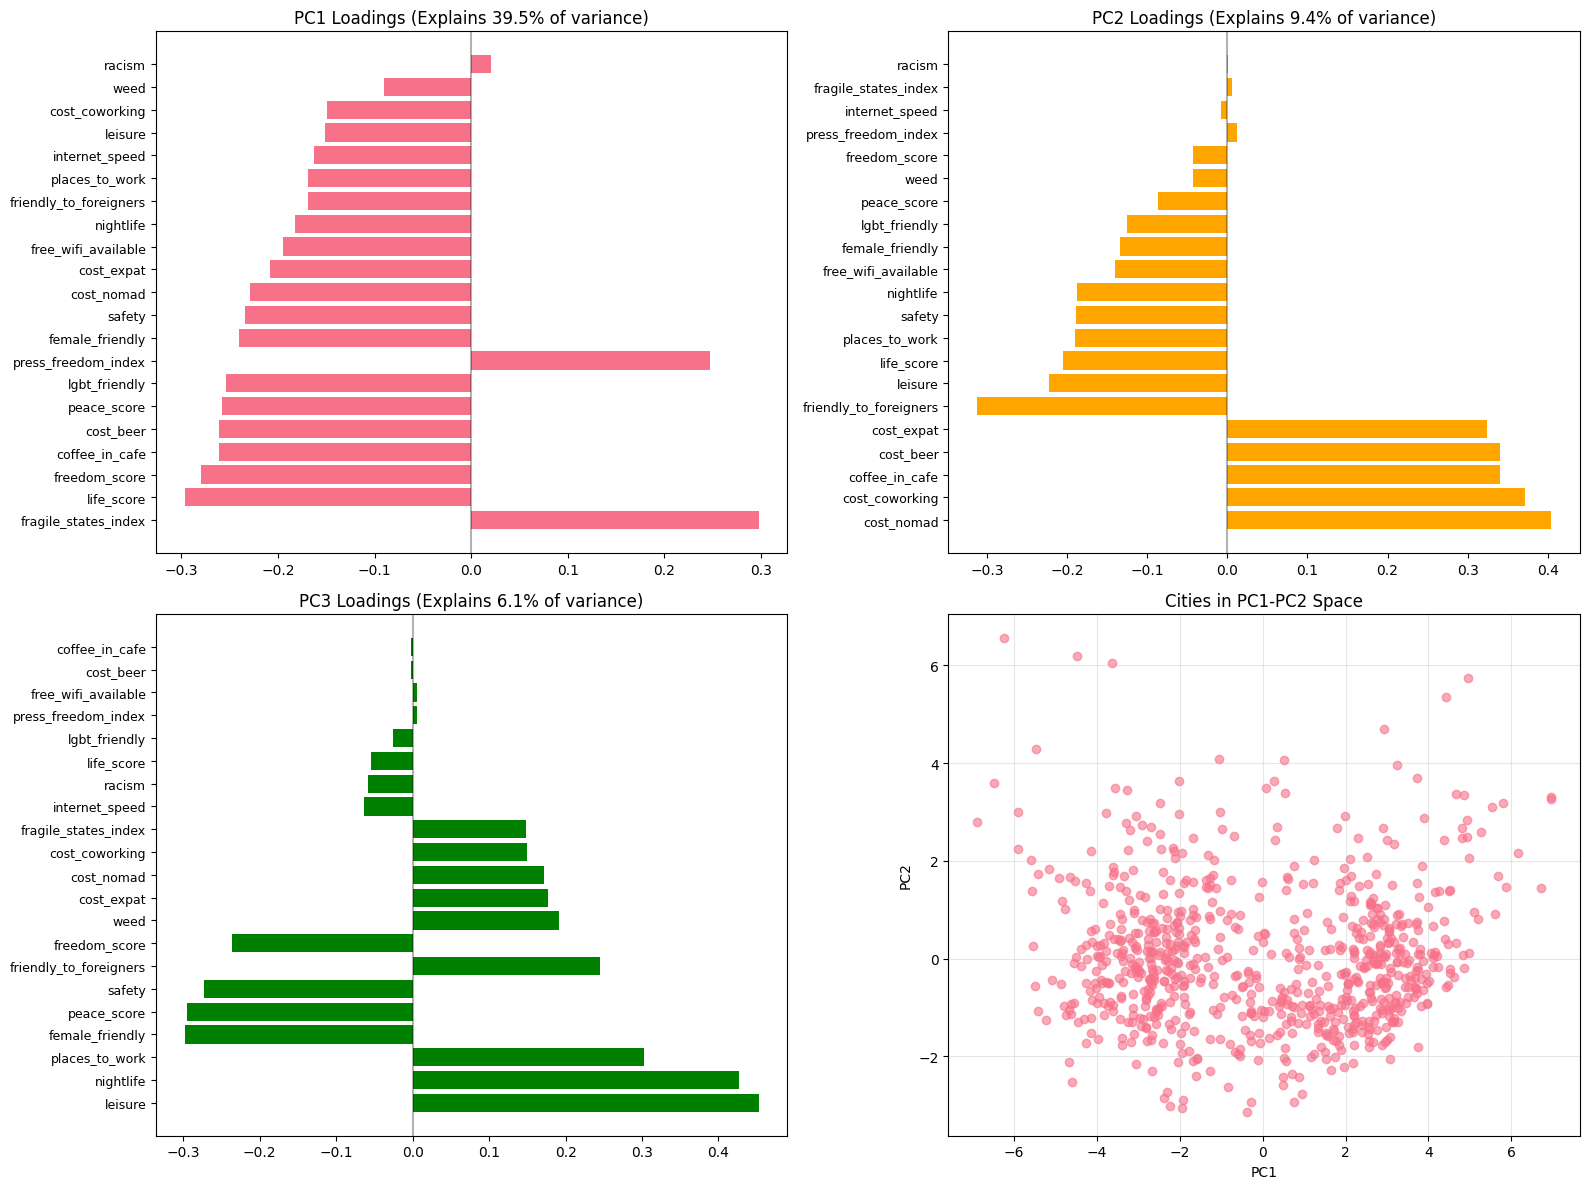

In [ ]:
# Visualize component loadings for interpretation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# PC1 loadings
pc1_loadings = components_df['PC1'].sort_values(key=abs, ascending=False)
axes[0,0].barh(range(len(pc1_loadings)), pc1_loadings.values)
axes[0,0].set_yticks(range(len(pc1_loadings)))
axes[0,0].set_yticklabels(pc1_loadings.index, fontsize=9)
axes[0,0].set_title(f'PC1 Loadings (Explains {explained_variance_ratio[0]*100:.1f}% of variance)')
axes[0,0].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# PC2 loadings
pc2_loadings = components_df['PC2'].sort_values(key=abs, ascending=False)
axes[0,1].barh(range(len(pc2_loadings)), pc2_loadings.values, color='orange')
axes[0,1].set_yticks(range(len(pc2_loadings)))
axes[0,1].set_yticklabels(pc2_loadings.index, fontsize=9)
axes[0,1].set_title(f'PC2 Loadings (Explains {explained_variance_ratio[1]*100:.1f}% of variance)')
axes[0,1].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# PC3 loadings
pc3_loadings = components_df['PC3'].sort_values(key=abs, ascending=False)
axes[1,0].barh(range(len(pc3_loadings)), pc3_loadings.values, color='green')
axes[1,0].set_yticks(range(len(pc3_loadings)))
axes[1,0].set_yticklabels(pc3_loadings.index, fontsize=9)
axes[1,0].set_title(f'PC3 Loadings (Explains {explained_variance_ratio[2]*100:.1f}% of variance)')
axes[1,0].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# PC1 vs PC2 scatter plot of cities
axes[1,1].scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.6)
axes[1,1].set_xlabel('PC1')
axes[1,1].set_ylabel('PC2')
axes[1,1].set_title('Cities in PC1-PC2 Space')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Business interpretation of components
print("BUSINESS INTERPRETATION:")
print("="*50)

# Analyze PC1
pc1_positive = components_df['PC1'][components_df['PC1'] > 0.2].sort_values(ascending=False)
pc1_negative = components_df['PC1'][components_df['PC1'] < -0.2].sort_values()

print(f"PC1 (explains {explained_variance_ratio[0]*100:.1f}% of variance):")
print("High positive loadings (higher PC1 scores):", list(pc1_positive.index))
print("High negative loadings (lower PC1 scores):", list(pc1_negative.index))
print("Business meaning: Political Instability/Fragility vs Stability Dimension")
print("NOTE: fragile_states_index & press_freedom_index are INVERSE coded (higher = worse)")
print("High PC1 = Politically unstable, restricted countries")
print("Low PC1 = Stable democracies with high freedom")
print()

# Analyze PC2
pc2_positive = components_df['PC2'][components_df['PC2'] > 0.2].sort_values(ascending=False)
pc2_negative = components_df['PC2'][components_df['PC2'] < -0.2].sort_values()

print(f"PC2 (explains {explained_variance_ratio[1]*100:.1f}% of variance):")
print("High positive loadings (higher PC2 scores):", list(pc2_positive.index))
print("High negative loadings (lower PC2 scores):", list(pc2_negative.index))
print("Business meaning: Cost vs Livability/Friendliness Dimension")
print("High PC2 = Expensive, potentially less welcoming places")
print("Low PC2 = Affordable, friendly, high quality of life destinations")

BUSINESS INTERPRETATION:
PC1 (explains 39.5% of variance):
High positive loadings (higher PC1 scores): ['fragile_states_index', 'press_freedom_index']
High negative loadings (lower PC1 scores): ['life_score', 'freedom_score', 'coffee_in_cafe', 'cost_beer', 'peace_score', 'lgbt_friendly', 'female_friendly', 'safety', 'cost_nomad', 'cost_expat']
Business meaning: Political Instability/Fragility vs Stability Dimension
NOTE: fragile_states_index & press_freedom_index are INVERSE coded (higher = worse)
High PC1 = Politically unstable, restricted countries
Low PC1 = Stable democracies with high freedom

PC2 (explains 9.4% of variance):
High positive loadings (higher PC2 scores): ['cost_nomad', 'cost_coworking', 'coffee_in_cafe', 'cost_beer', 'cost_expat']
High negative loadings (lower PC2 scores): ['friendly_to_foreigners', 'leisure', 'life_score']
Business meaning: Cost vs Livability/Friendliness Dimension
High PC2 = Expensive, potentially less welcoming places
Low PC2 = Affordable, friendl

## Exploring Cities in the Reduced Space

In [ ]:
# Create a dataframe with PCA results for easier analysis
pca_df = pd.DataFrame(
    pca_results[:, :3],  # First 3 components
    columns=['PC1', 'PC2', 'PC3']
)
pca_df['city'] = data['place']
pca_df['country'] = data['alpha-2']

# Find extreme cities for each component
print("CITIES AT EXTREMES OF EACH DIMENSION:")
print("="*50)

print("PC1 - Highest (politically unstable/restricted):")
print(pca_df.nlargest(5, 'PC1')[['city', 'country', 'PC1']].to_string(index=False))

print("\nPC1 - Lowest (politically stable/free):")
print(pca_df.nsmallest(5, 'PC1')[['city', 'country', 'PC1']].to_string(index=False))

print("\nPC2 - Highest (expensive/less livable):")
print(pca_df.nlargest(5, 'PC2')[['city', 'country', 'PC2']].to_string(index=False))

print("\nPC2 - Lowest (affordable/highly livable):")
print(pca_df.nsmallest(5, 'PC2')[['city', 'country', 'PC2']].to_string(index=False))

CITIES AT EXTREMES OF EACH DIMENSION:
PC1 - Highest (politically unstable/restricted):
      city country      PC1
  Damascus      SY 6.965471
      Hama      GB 6.959076
Rawalpindi      PK 6.717034
Gujranwala      PK 6.163135
 Islamabad      PK 5.873918

PC1 - Lowest (politically stable/free):
    city country       PC1
  Zurich      CH -6.890603
  Geneva      CH -6.475517
Lausanne      CH -6.244121
  Darwin      AU -5.910003
  Bergen      NO -5.898413

PC2 - Highest (expensive/less livable):
        city country      PC2
    Lausanne      CH 6.562235
Saint Helier      JE 6.184003
    Hamilton      BM 6.039559
   Pyongyang      KP 5.736088
       Basra      IQ 5.351881

PC2 - Lowest (affordable/highly livable):
   city country       PC2
Cordoba      AR -3.136097
 Taipei      TW -3.053131
  Daegu      KR -3.008404
Bangkok      TH -2.939550
    Nis      RS -2.925589


# 4. Method Comparison: When to Use What?

## Non-negative Matrix Factorization (NMF): Interpretable Components

In [ ]:
from sklearn.decomposition import NMF

# NMF requires non-negative data, so we use MinMax scaled data
nmf = NMF(n_components=4, random_state=42)
nmf_results = nmf.fit_transform(data_minmax_scaled)

# Examine NMF components
nmf_components_df = pd.DataFrame(
    nmf.components_,
    columns=data_for_analysis.columns,
    index=[f'NMF_Component_{i+1}' for i in range(4)]
)

print("NMF Components (each represents a 'pure' city archetype):")
print("="*60)

for i in range(4):
    component_name = f'NMF_Component_{i+1}'
    top_features = nmf_components_df.loc[component_name].sort_values(ascending=False)[:5]
    print(f"\n{component_name} - Top contributing factors:")
    for feature, weight in top_features.items():
        print(f"  {feature}: {weight:.3f}")

# Interpret business meaning of NMF components
print("\nBUSINESS INTERPRETATION OF NMF COMPONENTS:")
print("="*50)
print("Component 1: Party/Entertainment Destinations")
print("  - High nightlife, leisure, social environment")
print("Component 2: Politically Fragile/Restricted Areas")
print("  - High fragility and press restrictions")
print("Component 3: Cannabis-Friendly Locations")
print("  - Liberal drug policies")
print("Component 4: Safe, Women-Friendly Destinations")
print("  - High safety and gender equality")

NMF Components (each represents a 'pure' city archetype):

NMF_Component_1 - Top contributing factors:
  nightlife: 5.178
  leisure: 4.423
  places_to_work: 3.764
  friendly_to_foreigners: 3.539
  life_score: 2.331

NMF_Component_2 - Top contributing factors:
  fragile_states_index: 3.987
  press_freedom_index: 3.843
  friendly_to_foreigners: 2.259
  safety: 2.104
  life_score: 1.951

NMF_Component_3 - Top contributing factors:
  weed: 2.407
  places_to_work: 0.516
  nightlife: 0.452
  friendly_to_foreigners: 0.423
  leisure: 0.374

NMF_Component_4 - Top contributing factors:
  peace_score: 1.179
  female_friendly: 1.115
  safety: 0.976
  freedom_score: 0.949
  life_score: 0.748

BUSINESS INTERPRETATION OF NMF COMPONENTS:
Component 1: Party/Entertainment Destinations
  - High nightlife, leisure, social environment
Component 2: Politically Fragile/Restricted Areas
  - High fragility and press restrictions
Component 3: Cannabis-Friendly Locations
  - Liberal drug policies
Component 4: Sa

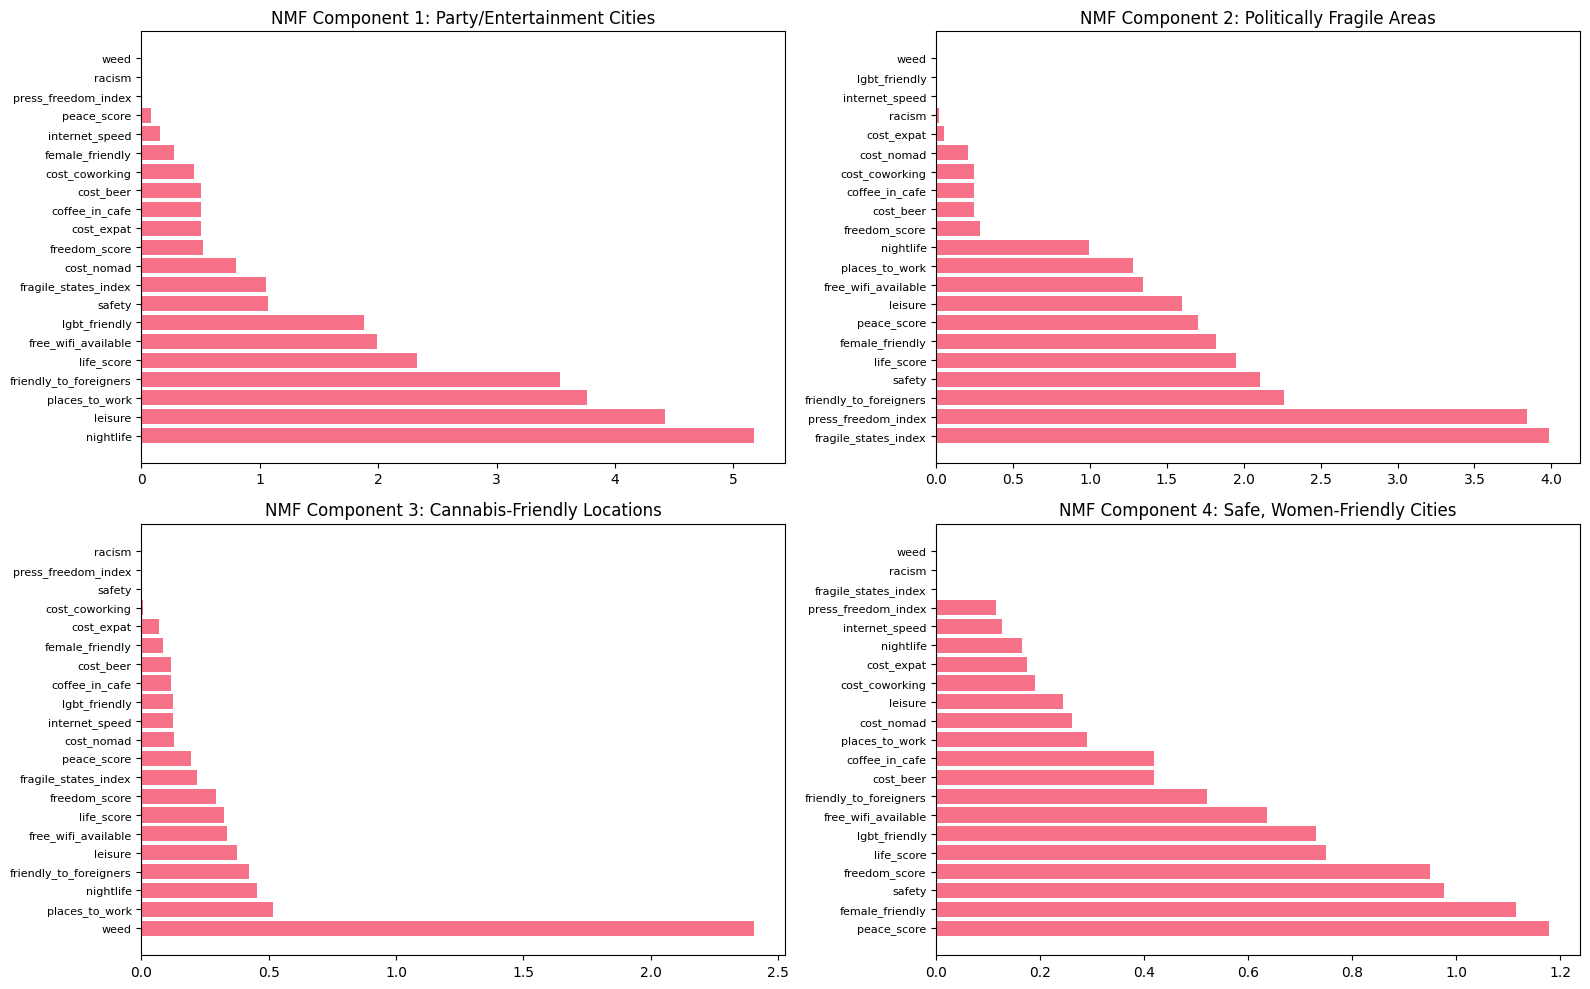

In [ ]:
# Visualize NMF components
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

component_labels = [
    'Party/Entertainment Cities',
    'Politically Fragile Areas',
    'Cannabis-Friendly Locations',
    'Safe, Women-Friendly Cities'
]

for i in range(4):
    component_values = nmf_components_df.iloc[i].sort_values(ascending=False)
    axes[i].barh(range(len(component_values)), component_values.values)
    axes[i].set_yticks(range(len(component_values)))
    axes[i].set_yticklabels(component_values.index, fontsize=8)
    axes[i].set_title(f'NMF Component {i+1}: {component_labels[i]}')

plt.tight_layout()
plt.show()

In [ ]:
# Compare PCA vs NMF interpretation
print("PCA vs NMF: Key Differences for Business Analysis")
print("="*60)
print("\nPCA (Principal Component Analysis):")
print("✓ Finds directions of maximum variance")
print("✓ Components can have negative loadings")
print("✓ Each component explains decreasing amounts of variance")
print("✓ Good for: Understanding overall data structure, data compression")

print("\nNMF (Non-negative Matrix Factorization):")
print("✓ Finds additive components (parts-based representation)")
print("✓ All weights are positive (more interpretable)")
print("✓ Components represent 'pure' archetypes that combine additively")
print("✓ Good for: Customer segments, topic modeling, business archetypes")

print("\nBusiness Decision Guide:")
print("- Use PCA when you want to understand the main axes of variation")
print("- Use NMF when you want interpretable 'types' that combine naturally")

PCA vs NMF: Key Differences for Business Analysis

PCA (Principal Component Analysis):
✓ Finds directions of maximum variance
✓ Components can have negative loadings
✓ Each component explains decreasing amounts of variance
✓ Good for: Understanding overall data structure, data compression

NMF (Non-negative Matrix Factorization):
✓ Finds additive components (parts-based representation)
✓ All weights are positive (more interpretable)
✓ Components represent 'pure' archetypes that combine additively
✓ Good for: Customer segments, topic modeling, business archetypes

Business Decision Guide:
- Use PCA when you want to understand the main axes of variation
- Use NMF when you want interpretable 'types' that combine naturally


# 5. Advanced Visualization: UMAP for Stakeholder Communication

## Making High-Dimensional Patterns Visible

In [ ]:
# Install UMAP if needed
try:
    import umap
except ImportError:
    print("Installing UMAP...")
    import subprocess
    subprocess.run(['pip', 'install', 'umap-learn'])
    import umap

# Apply UMAP for non-linear dimensionality reduction
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embedding = umap_reducer.fit_transform(data_standard_scaled)

# Create visualization dataframe
viz_df = pd.DataFrame({
    'UMAP1': umap_embedding[:, 0],
    'UMAP2': umap_embedding[:, 1],
    'city': data['place'],
    'country': data['alpha-2'],
    'region': data['region'],
    'cost_nomad': data['cost_nomad'],
    'safety': data['safety'],
    'nightlife': data['nightlife']
})

print("UMAP embedding shape:", umap_embedding.shape)
print("Sample of UMAP results:")
print(viz_df.head())

UMAP embedding shape: (780, 2)
Sample of UMAP results:
      UMAP1     UMAP2        city country  region  cost_nomad  safety  \
0  7.008017  8.119149    Budapest      HU  Europe      1364.0    0.60   
1  8.978703  8.035650  Chiang Mai      TH    Asia       777.0    0.80   
2  9.124882  7.841138      Phuket      TH    Asia      1012.0    0.80   
3  8.070603  8.382026     Bangkok      TH    Asia      1197.0    0.77   
4  8.068052  8.281796    Ko Samui      TH    Asia      1352.0    0.80   

   nightlife  
0       1.00  
1       0.40  
2       0.82  
3       1.00  
4       0.80  


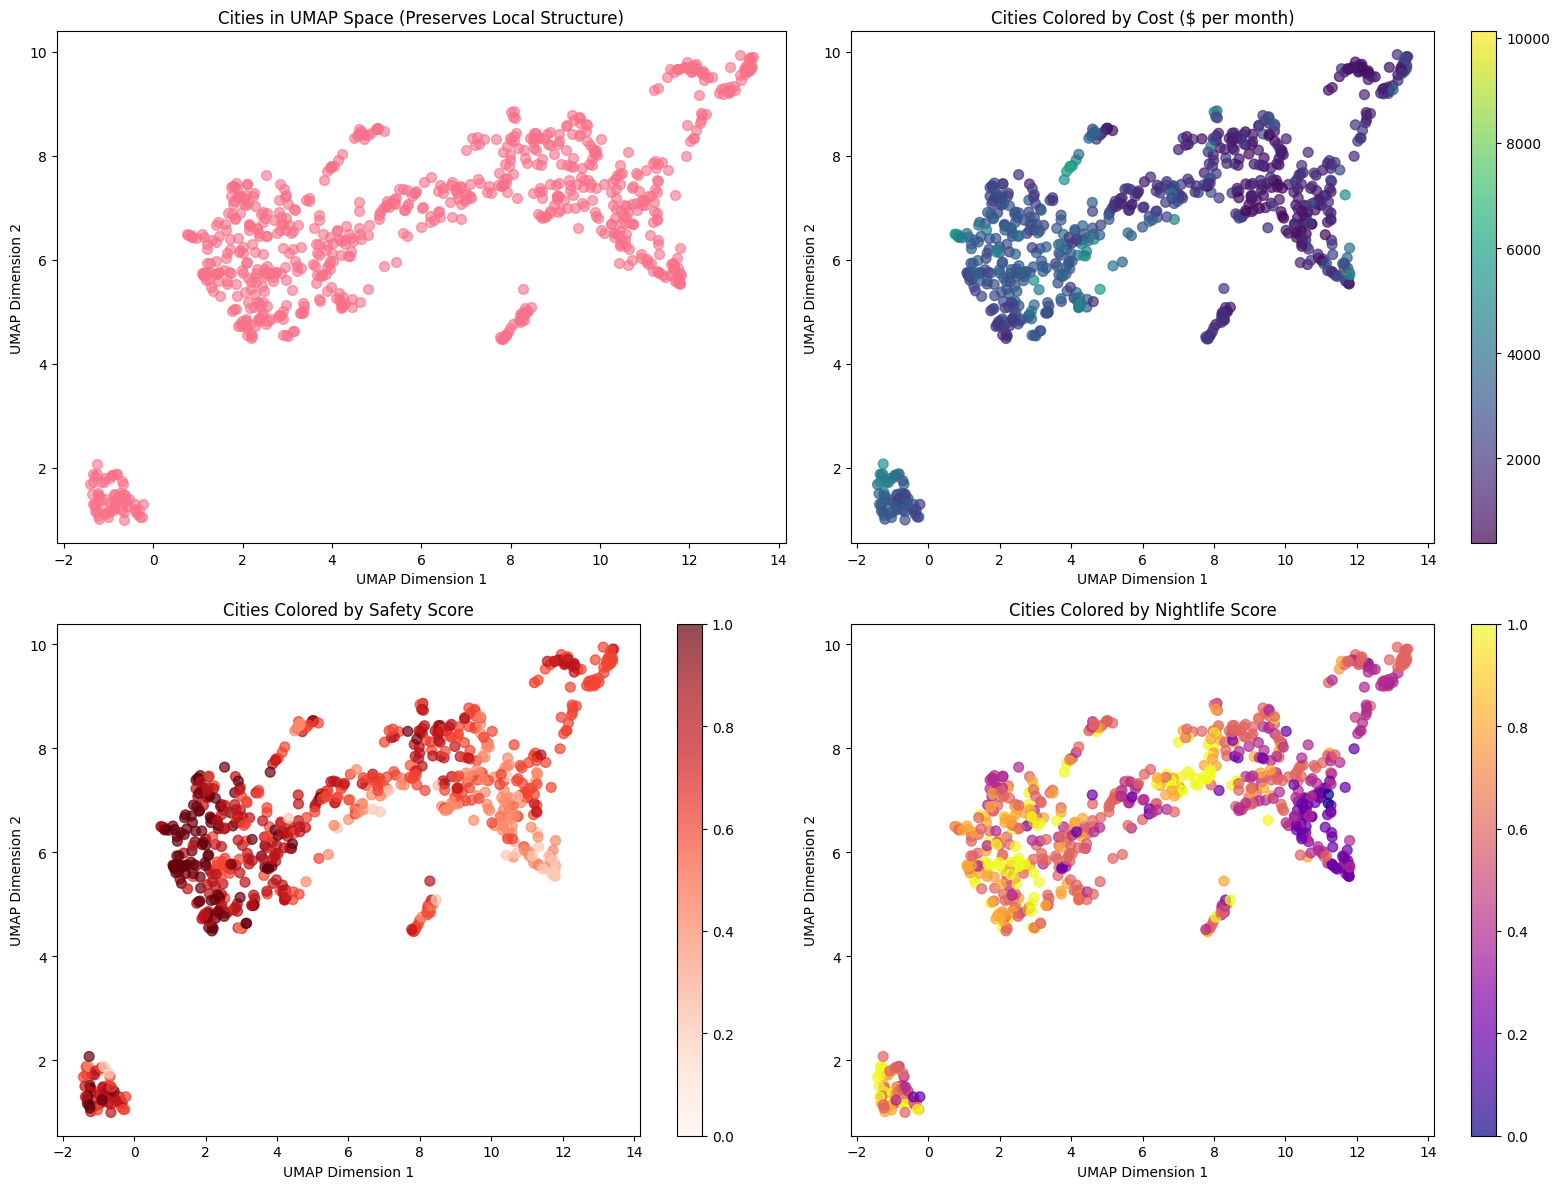

In [ ]:
# Create compelling visualizations for business stakeholders
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Basic UMAP scatter
axes[0,0].scatter(viz_df['UMAP1'], viz_df['UMAP2'], alpha=0.6, s=50)
axes[0,0].set_xlabel('UMAP Dimension 1')
axes[0,0].set_ylabel('UMAP Dimension 2')
axes[0,0].set_title('Cities in UMAP Space (Preserves Local Structure)')

# Color by cost
scatter1 = axes[0,1].scatter(viz_df['UMAP1'], viz_df['UMAP2'],
                            c=viz_df['cost_nomad'], cmap='viridis', alpha=0.7, s=50)
axes[0,1].set_xlabel('UMAP Dimension 1')
axes[0,1].set_ylabel('UMAP Dimension 2')
axes[0,1].set_title('Cities Colored by Cost ($ per month)')
plt.colorbar(scatter1, ax=axes[0,1])

# Color by safety
scatter2 = axes[1,0].scatter(viz_df['UMAP1'], viz_df['UMAP2'],
                            c=viz_df['safety'], cmap='Reds', alpha=0.7, s=50)
axes[1,0].set_xlabel('UMAP Dimension 1')
axes[1,0].set_ylabel('UMAP Dimension 2')
axes[1,0].set_title('Cities Colored by Safety Score')
plt.colorbar(scatter2, ax=axes[1,0])

# Color by nightlife
scatter3 = axes[1,1].scatter(viz_df['UMAP1'], viz_df['UMAP2'],
                            c=viz_df['nightlife'], cmap='plasma', alpha=0.7, s=50)
axes[1,1].set_xlabel('UMAP Dimension 1')
axes[1,1].set_ylabel('UMAP Dimension 2')
axes[1,1].set_title('Cities Colored by Nightlife Score')
plt.colorbar(scatter3, ax=axes[1,1])

plt.tight_layout()
plt.show()

In [ ]:
# Interactive visualization for stakeholder presentations
try:
    import plotly.express as px
    import plotly.graph_objects as go

    # Create interactive plot
    fig = px.scatter(viz_df,
                     x='UMAP1', y='UMAP2',
                     color='cost_nomad',
                     size='safety',
                     hover_name='city',
                     hover_data=['country', 'region', 'nightlife'],
                     title='Interactive Digital Nomad Cities Map',
                     color_continuous_scale='viridis')

    fig.update_layout(width=800, height=600)
    fig.show()

except ImportError:
    print("Plotly not available. Install with: pip install plotly")
    print("Using static visualization instead.")

In [ ]:
# Analyze UMAP spatial patterns
viz_df['umap_quadrant'] = 'Center'

# Define spatial regions based on UMAP coordinates
umap1_median = viz_df['UMAP1'].median()
umap2_median = viz_df['UMAP2'].median()

# Create more nuanced spatial divisions
conditions = [
    (viz_df['UMAP1'] < -5),  # Far left cluster
    (viz_df['UMAP1'] > 10),  # Far right cluster
    (viz_df['UMAP2'] > 5),   # Top of main cluster
    (viz_df['UMAP2'] < -5),  # Bottom of main cluster
]

labels = ['Left_Cluster', 'Right_Cluster', 'Top_Arc', 'Bottom_Arc']
viz_df['spatial_region'] = np.select(conditions, labels, default='Middle_Arc')

# Examine characteristics of each spatial region
print("SPATIAL ANALYSIS OF UMAP CLUSTERING:")
print("="*50)

for region in ['Left_Cluster', 'Right_Cluster', 'Top_Arc', 'Middle_Arc', 'Bottom_Arc']:
    region_cities = viz_df[viz_df['spatial_region'] == region]
    if len(region_cities) > 0:
        print(f"\n{region} ({len(region_cities)} cities):")
        print(f"  Avg Cost: ${region_cities['cost_nomad'].mean():.0f}")
        print(f"  Avg Safety: {region_cities['safety'].mean():.1f}")
        print(f"  Avg Nightlife: {region_cities['nightlife'].mean():.1f}")
        print(f"  Sample cities: {', '.join(region_cities['city'].head(5).tolist())}")
        print(f"  Countries: {', '.join(region_cities['country'].value_counts().head(3).index.tolist())}")

SPATIAL ANALYSIS OF UMAP CLUSTERING:

Right_Cluster (186 cities):
  Avg Cost: $1639
  Avg Safety: 0.5
  Avg Nightlife: 0.4
  Sample cities: Hua Hin, Yogyakarta, Surakarta, Semarang, Pekanbaru
  Countries: CN, IN, RU

Top_Arc (473 cities):
  Avg Cost: $2487
  Avg Safety: 0.7
  Avg Nightlife: 0.7
  Sample cities: Budapest, Chiang Mai, Phuket, Bangkok, Ko Samui
  Countries: US, CA, GB

Middle_Arc (121 cities):
  Avg Cost: $2790
  Avg Safety: 0.7
  Avg Nightlife: 0.7
  Sample cities: Prague, Brno, Austin, Miami, Portland
  Countries: US, ES, NL


In [ ]:
print("\nSUMMARY: UMAP REVEALS THE NOMAD DECISION HIERARCHY")
print("="*55)

print("\nThe UMAP visualization uncovers a more nuanced pattern than our initial PCA interpretation:")
print("\n🏛️ PRIMARY FILTER: Political Stability")
print("   • Stable countries form the main horseshoe-shaped cluster")
print("   • Politically unstable regions appear as separate outlier clusters")
print("   • This confirms PC1 as the dominant screening factor")

print("\n💰 SECONDARY SPECTRUM: Economic Development Gradient")
print("   • Right Cluster: Developing economies ($1,639 avg, 0.5 safety)")
print("   • Top Arc: Mixed economies ($2,487 avg, 0.7 safety)")
print("   • Middle Arc: Developed economies ($2,790 avg, 0.7 safety)")
print("   • Smooth transitions rather than discrete categories")

print("\n🎯 BUSINESS IMPLICATIONS:")
print("   • Nomads navigate a CONTINUOUS cost-development spectrum")
print("   • No hard 'budget vs premium' segments - it's a gradient")
print("   • Sweet spots exist along the development curve")
print("   • Recommendation systems should focus on position along continuum")

print("\n💡 KEY INSIGHT:")
print("   The horseshoe pattern reveals that nomad city choice follows a")
print("   hierarchy: Political stability first, then individual tolerance")
print("   for trading cost against infrastructure quality.")

print("\n📊 METHODOLOGICAL LEARNING:")
print("   • PCA captures major variance axes (stability, cost)")
print("   • UMAP reveals the actual shape of decision space (continuous)")
print("   • Linear and non-linear methods complement each other")
print("   • Always validate PCA insights with visualization methods")


SUMMARY: UMAP REVEALS THE NOMAD DECISION HIERARCHY

The UMAP visualization uncovers a more nuanced pattern than our initial PCA interpretation:

🏛️ PRIMARY FILTER: Political Stability
   • Stable countries form the main horseshoe-shaped cluster
   • Politically unstable regions appear as separate outlier clusters
   • This confirms PC1 as the dominant screening factor

💰 SECONDARY SPECTRUM: Economic Development Gradient
   • Right Cluster: Developing economies ($1,639 avg, 0.5 safety)
   • Top Arc: Mixed economies ($2,487 avg, 0.7 safety)
   • Middle Arc: Developed economies ($2,790 avg, 0.7 safety)
   • Smooth transitions rather than discrete categories

🎯 BUSINESS IMPLICATIONS:
   • Nomads navigate a CONTINUOUS cost-development spectrum
   • No hard 'budget vs premium' segments - it's a gradient
   • Sweet spots exist along the development curve
   • Recommendation systems should focus on position along continuum

💡 KEY INSIGHT:
   The horseshoe pattern reveals that nomad city choic

In [ ]:
# Create 3D UMAP embedding for interactive exploration
umap_3d = umap.UMAP(n_components=3, random_state=42)
umap_3d_embedding = umap_3d.fit_transform(data_standard_scaled)

# Create 3D visualization dataframe
viz_3d_df = pd.DataFrame({
    'UMAP1': umap_3d_embedding[:, 0],
    'UMAP2': umap_3d_embedding[:, 1],
    'UMAP3': umap_3d_embedding[:, 2],
    'city': data['place'],
    'country': data['alpha-2'],
    'region': data['region'],
    'cost_nomad': data['cost_nomad'],
    'safety': data['safety'],
    'nightlife': data['nightlife'],
    'freedom_score': data['freedom_score']
})

# Interactive 3D scatter plot
try:
    fig = px.scatter_3d(viz_3d_df,
                        x='UMAP1', y='UMAP2', z='UMAP3',
                        color='cost_nomad',
                        size='safety',
                        hover_name='city',
                        hover_data=['country', 'region', 'nightlife', 'freedom_score'],
                        title='3D UMAP: Digital Nomad Cities in Reduced Space',
                        color_continuous_scale='viridis',
                        opacity=0.7)

    fig.update_layout(
        scene=dict(
            xaxis_title='UMAP Dimension 1',
            yaxis_title='UMAP Dimension 2',
            zaxis_title='UMAP Dimension 3'
        ),
        width=900,
        height=700
    )
    fig.show()

    print("🎯 3D UMAP Insights:")
    print("Rotate and zoom to explore the full structure!")
    print("Look for spirals, layered clusters, or branching patterns.")

except ImportError:
    print("Plotly required for 3D visualization. Install with: pip install plotly")

🎯 3D UMAP Insights:
Rotate and zoom to explore the full structure!
Look for spirals, layered clusters, or branching patterns.


In [ ]:
# Highlight specific cities in 3D UMAP
def highlight_city_3d(target_city):
    # Create a copy of the dataframe with highlighting info
    viz_highlight = viz_3d_df.copy()
    viz_highlight['is_target'] = viz_highlight['city'] == target_city
    viz_highlight['marker_size'] = np.where(viz_highlight['is_target'], 15, 8)
    viz_highlight['marker_symbol'] = np.where(viz_highlight['is_target'], 'diamond', 'circle')

    # Create the plot
    fig = px.scatter_3d(viz_highlight,
                        x='UMAP1', y='UMAP2', z='UMAP3',
                        color='cost_nomad',
                        size='marker_size',
                        symbol='marker_symbol',
                        hover_name='city',
                        hover_data=['country', 'region', 'nightlife', 'freedom_score'],
                        title=f'3D UMAP: Highlighting {target_city}',
                        color_continuous_scale='viridis',
                        opacity=0.7)

    # Customize the highlighted city
    if target_city in viz_highlight['city'].values:
        target_data = viz_highlight[viz_highlight['city'] == target_city].iloc[0]

        # Add annotation for the target city
        fig.add_scatter3d(
            x=[target_data['UMAP1']],
            y=[target_data['UMAP2']],
            z=[target_data['UMAP3']],
            mode='markers+text',
            marker=dict(size=20, color='red', symbol='diamond'),
            text=[target_city],
            textposition="top center",
            name=f'{target_city} (Highlighted)',
            showlegend=True
        )

        print(f"📍 {target_city} Details:")
        print(f"   Cost: ${target_data['cost_nomad']:.0f}/month")
        print(f"   Safety: {target_data['safety']:.1f}")
        print(f"   Nightlife: {target_data['nightlife']:.1f}")
        print(f"   Freedom Score: {target_data['freedom_score']:.1f}")
        print(f"   3D Position: ({target_data['UMAP1']:.2f}, {target_data['UMAP2']:.2f}, {target_data['UMAP3']:.2f})")
    else:
        print(f"City '{target_city}' not found in dataset")
        return None

    fig.update_layout(
        scene=dict(
            xaxis_title='UMAP Dimension 1',
            yaxis_title='UMAP Dimension 2',
            zaxis_title='UMAP Dimension 3'
        ),
        width=900,
        height=700
    )

    return fig

# Highlight Chengdu
fig_chengdu = highlight_city_3d("Chengdu")
if fig_chengdu:
    fig_chengdu.show()

📍 Chengdu Details:
   Cost: $944/month
   Safety: 0.8
   Nightlife: 0.6
   Freedom Score: 0.2
   3D Position: (9.15, 7.48, 5.66)


# 6. Business Insights Synthesis

## Key Findings: What We Learned About Nomad Preferences

In [ ]:
# Summarize the key business insights
print("BUSINESS INSIGHTS FROM DIMENSIONALITY REDUCTION")
print("="*60)

print(f"\n1. DATA COMPLEXITY REDUCTION:")
print(f"   ✓ Reduced {len(data_for_analysis.columns)} variables to 3 key dimensions")
print(f"   ✓ First 3 components explain {cumulative_variance[2]*100:.1f}% of variation")
print(f"   ✓ Enables clear decision framework for nomads")

print(f"\n2. PRIMARY DIMENSION DISCOVERED:")
primary_dimension = "Political Stability vs Instability"
print(f"   ✓ {primary_dimension} is the dominant factor")
print(f"   ✓ Explains {explained_variance_ratio[0]*100:.1f}% of nomad city differences")
print(f"   ✓ Nomads prioritize political freedom and stability over other factors")

print(f"\n3. SECONDARY PATTERNS:")
print(f"   ✓ Cost vs Livability trade-offs create the second major dimension")
print(f"   ✓ Lifestyle factors (nightlife, social environment) group together")
print(f"   ✓ Geographic patterns reflect political and economic development")

print(f"\n4. BUSINESS APPLICATIONS:")
print(f"   ✓ Two-axis recommendation framework: Stability + Affordability")
print(f"   ✓ Market segmentation based on risk tolerance and budget")
print(f"   ✓ Data-driven travel advisory and city comparisons")

BUSINESS INSIGHTS FROM DIMENSIONALITY REDUCTION

1. DATA COMPLEXITY REDUCTION:
   ✓ Reduced 21 variables to 3 key dimensions
   ✓ First 3 components explain 55.0% of variation
   ✓ Enables clear decision framework for nomads

2. PRIMARY DIMENSION DISCOVERED:
   ✓ Political Stability vs Instability is the dominant factor
   ✓ Explains 39.5% of nomad city differences
   ✓ Nomads prioritize political freedom and stability over other factors

3. SECONDARY PATTERNS:
   ✓ Cost vs Livability trade-offs create the second major dimension
   ✓ Lifestyle factors (nightlife, social environment) group together
   ✓ Geographic patterns reflect political and economic development

4. BUSINESS APPLICATIONS:
   ✓ Two-axis recommendation framework: Stability + Affordability
   ✓ Market segmentation based on risk tolerance and budget
   ✓ Data-driven travel advisory and city comparisons


In [ ]:
# Create a simple business framework based on corrected PCA insights
print("\nBUSINESS FRAMEWORK:")
print("="*40)

# Define city types based on corrected PC1 and PC2 interpretation
pca_df['city_type'] = 'Unknown'

# Simple quadrant classification using corrected interpretations
high_pc1_threshold = pca_df['PC1'].quantile(0.6)  # High = Unstable
low_pc1_threshold = pca_df['PC1'].quantile(0.4)   # Low = Stable
high_pc2_threshold = pca_df['PC2'].quantile(0.6)  # High = Expensive
low_pc2_threshold = pca_df['PC2'].quantile(0.4)   # Low = Affordable

conditions = [
    (pca_df['PC1'] <= low_pc1_threshold) & (pca_df['PC2'] <= low_pc2_threshold),   # Stable + Affordable
    (pca_df['PC1'] <= low_pc1_threshold) & (pca_df['PC2'] >= high_pc2_threshold),  # Stable + Expensive
    (pca_df['PC1'] >= high_pc1_threshold) & (pca_df['PC2'] <= low_pc2_threshold),  # Unstable + Affordable
    (pca_df['PC1'] >= high_pc1_threshold) & (pca_df['PC2'] >= high_pc2_threshold)  # Unstable + Expensive
]

labels = ['Stable & Affordable', 'Stable & Expensive', 'Risky & Cheap', 'Risky & Expensive']

pca_df['city_type'] = np.select(conditions, labels, default='Moderate')

# Show examples of each city type
print("NOMAD CITY CATEGORIES (Based on Data-Driven Insights):")
for city_type in ['Stable & Affordable', 'Stable & Expensive', 'Risky & Cheap', 'Risky & Expensive']:
    examples = pca_df[pca_df['city_type'] == city_type].head(3)
    if len(examples) > 0:
        print(f"\n{city_type} Cities:")
        for _, row in examples.iterrows():
            print(f"  - {row['city']}, {row['country']}")


BUSINESS FRAMEWORK:
NOMAD CITY CATEGORIES (Based on Data-Driven Insights):

Stable & Affordable Cities:
  - Prague, CZ
  - Taipei, TW
  - Austin, US

Stable & Expensive Cities:
  - Oakland, US
  - Houston, US
  - Denver, US

Risky & Cheap Cities:
  - Chiang Mai, TH
  - Ko Lanta, TH
  - Chiang Rai, TH

Risky & Expensive Cities:
  - Sorocaba, BR
  - Sao Luis, BR
  - Hama, GB


# 7. Looking Ahead: Applications Preview

## How Dimensionality Reduction Enables Advanced Analytics

In [ ]:
print("NEXT STEPS: FROM INSIGHTS TO APPLICATIONS")
print("="*50)

print("\n🎯 CLUSTERING (Next Lecture):")
print("   • Use these reduced dimensions for nomad segmentation")
print("   • K-means clustering on PC1 (stability), PC2 (cost)")
print("   • Discover natural nomad risk/budget profiles")

print("\n🔍 RECOMMENDATION SYSTEMS (Lecture 3):")
print("   • Calculate similarity in reduced space")
print("   • 'Cities similar to Barcelona' using political stability + cost profiles")
print("   • Personalized recommendations based on risk tolerance and budget")

print("\n📊 BUSINESS STRATEGY:")
print("   • Market sizing for stability-conscious vs risk-tolerant nomads")
print("   • Insurance/safety products for different risk profiles")
print("   • Targeted marketing based on political and economic preferences")

# Quick demonstration of similarity calculation
print("\n" + "="*50)
print("QUICK DEMO: City Similarity in Reduced Space")

# Find cities similar to a popular nomad destination
target_city = "Barcelona"
if target_city in pca_df['city'].values:
    target_idx = pca_df[pca_df['city'] == target_city].index[0]
    target_coords = pca_results[target_idx, :3]  # First 3 PCs

    # Calculate Euclidean distances
    distances = []
    for i, row in pca_df.iterrows():
        if i != target_idx:
            city_coords = pca_results[i, :3]
            distance = np.linalg.norm(target_coords - city_coords)
            distances.append((row['city'], row['country'], distance))

    # Sort and show most similar cities
    distances.sort(key=lambda x: x[2])
    print(f"\nCities most similar to {target_city} (political stability + cost profile):")
    for i in range(5):
        city, country, dist = distances[i]
        print(f"  {i+1}. {city}, {country} (distance: {dist:.2f})")
else:
    print(f"\n{target_city} not found in dataset")

print("\nThis similarity is based on political stability and cost patterns!")

NEXT STEPS: FROM INSIGHTS TO APPLICATIONS

🎯 CLUSTERING (Next Lecture):
   • Use these reduced dimensions for nomad segmentation
   • K-means clustering on PC1 (stability), PC2 (cost)
   • Discover natural nomad risk/budget profiles

🔍 RECOMMENDATION SYSTEMS (Lecture 3):
   • Calculate similarity in reduced space
   • 'Cities similar to Barcelona' using political stability + cost profiles
   • Personalized recommendations based on risk tolerance and budget

📊 BUSINESS STRATEGY:
   • Market sizing for stability-conscious vs risk-tolerant nomads
   • Insurance/safety products for different risk profiles
   • Targeted marketing based on political and economic preferences

QUICK DEMO: City Similarity in Reduced Space

Cities most similar to Barcelona (political stability + cost profile):
  1. Palma De Mallorca, ES (distance: 0.32)
  2. Baton Rouge, US (distance: 0.34)
  3. Florence, IT (distance: 0.47)
  4. Kansas City, US (distance: 0.47)
  5. Austin, US (distance: 0.74)

This similarity 

## Course Wrap-up

In [ ]:
print("\n" + "="*60)
print("DIMENSIONALITY REDUCTION: KEY TAKEAWAYS")
print("="*60)

print("\n🎯 BUSINESS VALUE:")
print("   • Simplifies complex decisions (21 variables → 3 dimensions)")
print("   • Reveals hidden patterns in location preferences")
print("   • Enables data-driven strategy and segmentation")

print("\n🔧 TECHNICAL SKILLS:")
print("   • PCA for variance-based dimensionality reduction")
print("   • NMF for interpretable, additive components")
print("   • UMAP for compelling stakeholder visualizations")
print("   • Proper data preprocessing and scaling")
print("   • Critical interpretation of component loadings")

print("\n💡 BUSINESS INSIGHTS:")
print("   • Political stability is the primary nomad decision factor")
print("   • Cost vs livability creates the secondary trade-off dimension")
print("   • Risk tolerance and budget constraints drive market segments")
print("   • Data patterns often contradict business assumptions")

print("\n🚀 NEXT APPLICATIONS:")
print("   • Clustering: Risk/budget-based customer segmentation")
print("   • Recommendations: Stability and cost-aware city matching")
print("   • Strategy: Political risk and economic data-driven decisions")

print("\nKey Learning: Let the data guide interpretation rather than imposing assumptions!")


DIMENSIONALITY REDUCTION: KEY TAKEAWAYS

🎯 BUSINESS VALUE:
   • Simplifies complex decisions (21 variables → 3 dimensions)
   • Reveals hidden patterns in location preferences
   • Enables data-driven strategy and segmentation

🔧 TECHNICAL SKILLS:
   • PCA for variance-based dimensionality reduction
   • NMF for interpretable, additive components
   • UMAP for compelling stakeholder visualizations
   • Proper data preprocessing and scaling
   • Critical interpretation of component loadings

💡 BUSINESS INSIGHTS:
   • Political stability is the primary nomad decision factor
   • Cost vs livability creates the secondary trade-off dimension
   • Risk tolerance and budget constraints drive market segments
   • Data patterns often contradict business assumptions

🚀 NEXT APPLICATIONS:
   • Clustering: Risk/budget-based customer segmentation
   • Recommendations: Stability and cost-aware city matching
   • Strategy: Political risk and economic data-driven decisions

Key Learning: Let the data